# Generate datasets

The purpose of this notebook is to create two foundational datasets:<br/>
1) admission_diagnosis_table: This dataset contains the most important patient demographic and diagnosis data<br/>
for all admissions.<br/>
2) last_reading: This dataset contains the final reading for 35 chart and lab items for each admission.<br/><br/>
The intention for creating these datasets is that they provide all the data required for selecting the patient<br/>
groups and building the model without the need to directly query the raw data again.<br/><br/>
Both datasets are then saved on AWS S3 to be accessed in subsequent notebooks.

In [1]:
import os
import sys
import pandas as pd

In [2]:
#### MUST DELETE
#import warnings
#warnings.filterwarnings('ignore')
#pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Set up paths & import functions
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')
sys.path.insert(0, src_folder)
from generate_datasets import *
from stats_and_visualisations import *
from s3_storage import *

/Users/James/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## admission_diagnosis_table
This dataset includes the most important patient demographic and diagnosis data for all admissions.<br/><br/>
It draws from 3 primary tables in the raw data:<br/>
1) patients - for data specific to patients such as their gender and year of birth.<br/>
2) admissions - to find all admissions associated with each patient.<br/>
3) diagnoses_icd - to find all diagnoses made during each admission.<br/><br/>
The final dataset is at the diagnosis level, meaning there is 1 row per diagnosis per admission.<br/><br/>
Several additional columns are added to the dataset to enable easier analysis:<br/>
1) total_admissions: gives the total number of admissions associated with each subject_id.<br/>
2) admission_number: gives a chronological representation of each admission for each patient, eg 1 would be a<br/>
patient's 1st admission, 2 would be a patient's 2nd admission, etc.<br/>
3) age_on_admission: the difference between dob and admittime. This is correct for all patients under 89, however<br/>
the dob was shifted in the raw data for all patients over 89 to obscure their age to comply with HIIPA.<br/>
Therefore, all patients over 89 are listed as being 89, and an additional flag age_on_admission_shifted was<br/>
created to show when this is the case.<br/>
4) age_adm_bucket: the above age data bucketed into the ranges <45, 45-60, 60-75, 75-89, 89.<br/>
5) ethnicity_simple: cleaned version of the standard ethnicity data to reduce and simplify the ethnicity buckets.<br/> For detailed analysis of ethnicity this shouldn't be used.<br/>

In [4]:
# Create the admission_diagnosis_table and save to S3
admission_diagnosis_table = create_admission_diagnosis_table()
to_s3(obj=admission_diagnosis_table, bucket='mimic-jamesi', filename='admission_diagnosis_table.csv')
admission_diagnosis_table.head(100)

subject_id gender        dob        dod  expire_flag  total_admissions  \
0         3572      M 2162-11-23        NaT            0                 1   
1         3572      M 2162-11-23        NaT            0                 1   
2         3572      M 2162-11-23        NaT            0                 1   
3         3572      M 2162-11-23        NaT            0                 1   
4         3572      M 2162-11-23        NaT            0                 1   
5         3572      M 2162-11-23        NaT            0                 1   
6         3572      M 2162-11-23        NaT            0                 1   
7         3572      M 2162-11-23        NaT            0                 1   
8        76921      F 2097-09-11 2184-12-18            1                 1   
9        76921      F 2097-09-11 2184-12-18            1                 1   
10       76921      F 2097-09-11 2184-12-18            1                 1   
11       76921      F 2097-09-11 2184-12-18            1                 1   
12       76921      F 2097-09-11 2184-12-18            1                 1   
13       76921      F 2097-09-11 2184-12-18            1                 1   
14       76921      F 2097-09-11 2184-12-18            1                 1   
15       76921      F 2097-09-11 2184-12-18            1                 1   
16       76921      F 2097-09-11 2184-12-18            1                 1   
17       76921      F 2097-09-11 2184-12-18            1                 1   
18       76921      F 2097-09-11 2184-12-18            1                 1   
19       76921      F 2097-09-11 2184-12-18            1                 1   
20       76921      F 2097-09-11 2184-12-18            1                 1   
21       76921      F 2097-09-11 2184-12-18            1                 1   
22       76921      F 2097-09-11 2184-12-18            1                 1   
23       76921      F 2097-09-11 2184-12-18            1                 1   
24       76921      F 2097-09-11 2184-12-18            1                 1   
25       76921      F 2097-09-11 2184-12-18            1                 1   
26       76921      F 2097-09-11 2184-12-18            1                 1   
27       76921      F 2097-09-11 2184-12-18            1                 1   
28       76921      F 2097-09-11 2184-12-18            1                 1   
29       76921      F 2097-09-11 2184-12-18            1                 1   
..         ...    ...        ...        ...          ...               ...   
70       65594      M 2108-01-02 2172-01-27            1                 2   
71       65594      M 2108-01-02 2172-01-27            1                 2   
72       65594      M 2108-01-02 2172-01-27            1                 2   
73       65594      M 2108-01-02 2172-01-27            1                 2   
74       97409      M 2113-06-02        NaT            0                 1   
75       97409      M 2113-06-02        NaT            0                 1   
76       97409      M 2113-06-02        NaT            0                 1   
77       97409      M 2113-06-02        NaT            0                 1   
78       97409      M 2113-06-02        NaT            0                 1   
79       97409      M 2113-06-02        NaT            0                 1   
80       97409      M 2113-06-02        NaT            0                 1   
81       18783      M 2053-04-08        NaT            0                 1   
82       18783      M 2053-04-08        NaT            0                 1   
83       18783      M 2053-04-08        NaT            0                 1   
84       18783      M 2053-04-08        NaT            0                 1   
85       18783      M 2053-04-08        NaT            0                 1   
86       18783      M 2053-04-08        NaT            0                 1   
87       18783      M 2053-04-08        NaT            0                 1   
88       18783      M 2053-04-08        NaT            0                 1   
89       10086      F 2157

# first_reading

In [5]:
# Import chart IDs
item_lookup = from_s3(bucket='mimic-jamesi', filename='item_lookup.csv', index_col=0)
item_lookup

new_id               name  itemid  \
0   9999001         Creatinine   50912   
1   9999002         Hematocrit   51221   
2   9999003                BUN  225624   
3   9999003                BUN    1162   
4   9999003                BUN     781   
5   9999004           Chloride   50902   
6   9999005  White blood cells   51301   
7   9999006        Bicarbonate   50882   
8   9999007     Platelet Count   51265   
9   9999008             Sodium   50983   
10  9999009         Hemoglobin   51222   
11  9999010          Potassium   50971   
12  9999011               MCHC   51249   
13  9999012    Red Blood Cells   51279   
14  9999013                RDW   51277   
15  9999014          Anion Gap   50868   
16  9999015            Glucose   50931   
17  9999016                MCV   51250   
18  9999017                MCH   51248   
19  9999018                 HR     211   
20  9999018                 HR  220045   
21  9999020          Magnesium   50960   
22  9999021    Calcium (Total)   50893   
23  9999022         Phosphorus     827   
24  9999022         Phosphorus    1534   
25  9999022         Phosphorus  225677   
26  9999024   Admission weight     762   
27  9999024   Admission weight  226512   
28  9999025   Respiratory rate     618   
29  9999025   Respiratory rate  220210   
30  9999026       BP diastolic  220180   
31  9999026       BP diastolic    8441   
32  9999027        BP systolic  220179   
33  9999027        BP systolic     455   
34  9999028            BP mean  220181   
35  9999028            BP mean     456   
36  9999029      Temperature F  223761   
37  9999029      Temperature F     678   
38  9999030      Urea Nitrogen   51006   
39  9999031                PTT   51275   
40  9999032        Lymphocytes   51244   
41  9999033          Monocytes   51254   
42  9999034        Neutrophils   51256   
43  9999035          Basophils   51146   
44  9999036        Eosinophils   51200   
45  9999037                 pH   50820   
46  9999039            Lactate   50813   
47  9999040  Oxygen saturation     834   
48  9999040  Oxygen saturation  220277   
49  9999041                PO2   50821   
50  9999042               PCO2   50818   

                                          description  
0   Using just from labevents due to high volume i...  
1   Using just from labevents due to high volume i...  
2   Combining across sources due to similar distri...  
3   Combining across sources due to similar distri...  
4   Combining across sources due to similar distri...  
5   Using just from labevents due to high volume i...  
6   Using just from labevents due to high volume i...  
7   Using just from labevents due to high volume i...  
8   Using just from labevents due to high volume i...  
9   Using just from labevents due to high volume i...  
10  Using just from labevents due to high volume i...  
11  Using just from labevents due to high volume i...  
12  Using just from labevents due to high volume i...  
13  Using just from labevents due to high volume i...  
14  Using just from labevents due to high volume i...  
15  Using just from labevents due to high volume i...  
16  Using just 1 from labevents, due to multiple d...  
17  Using just from labevents due to high volume i...  
18  Using just from labevents due to high volume i...  
19  Combining due to similar distributions (after ...  
20  Combining due to similar distributions (after ...  
21  Using just from labevents due to high volume i...  
22  Using just from labevents due to high volume i...  
23  Combining due to similar distributions (after ...  
24  Combining due to similar distributions (after ...  
25  Combining due to similar distributions (after ...  
26             Combining due to similar distributions  
27             Combining due to similar distributions  
28             Combining due to similar distributions  
29             Combining due to similar distributions  
30             Combining due to similar distributions  
31             Combining due

In [6]:
# Take all readings for these IDs from the raw data
ids = tuple(item_lookup.itemid.tolist())

# Lab events
lab = get_data(query = "SELECT DISTINCT\
                            subject_id\
                            ,hadm_id\
                            ,charttime\
                            ,itemid\
                            ,valuenum\
                        FROM\
                            mimiciii.labevents\
                        WHERE valuenum IS NOT null\
                        AND itemid IN {}".format(ids))

# Lab events
chart = get_data(query = "SELECT DISTINCT\
                            subject_id\
                            ,hadm_id\
                            ,charttime\
                            ,itemid\
                            ,valuenum\
                        FROM\
                            mimiciii.chartevents\
                        WHERE valuenum IS NOT null\
                        AND itemid IN {}".format(ids))

df = lab.append(chart)

# Merge on lookup so that identical concepts can be combined, identified through new_id
df = pd.merge(df, item_lookup[['itemid', 'new_id', 'name']], how='left', left_on='itemid', right_on='itemid')
df.head()

subject_id   hadm_id           charttime  itemid  valuenum   new_id  \
0           2  163353.0 2138-07-17 20:48:00   51146       0.0  9999035   
1           2  163353.0 2138-07-17 20:48:00   51200       0.0  9999036   
2           2  163353.0 2138-07-17 20:48:00   51221       0.0  9999002   
3           2  163353.0 2138-07-17 20:48:00   51222       0.0  9999009   
4           2  163353.0 2138-07-17 20:48:00   51244       0.0  9999032   

          name  
0    Basophils  
1  Eosinophils  
2   Hematocrit  
3   Hemoglobin  
4  Lymphocytes

In [7]:
def compare_itemids(df):

    '''
    This function takes a dataframe containing chart & lab events and outputs visualisations and stats for
    all itemids that are contained. The purpose of this is that if there are multiple itemids that seem to contain
    a similar concept, their values can be compared to see whether this is the case.
    
    The input dataframe must contain the following columns:
    1) itemid: used to identify the chart/ lab event items
    2) valuenum: contains the numerical values of the observations for each itemid
    3) hadm_id: used to identify each admission
    
    The dataframe can be at either the  admission or chart observation level, but the output will reflect this.
    i.e, if the input is at the admission level then the output stats will be at the admission level, whereas if
    the input is at the chart observation level then the output stats will be for every observation recorded across
    all admissions
    
    '''
    
    df.drop_duplicates(inplace=True)    
    df.dropna(inplace=True)

    # Find all itemids so that they can be compared against each other
    item_ids = df.itemid.unique().tolist()

    # --- Plot a KDE: 1 line for each itemid
    plt.figure(figsize = (7, 5))
    for i in item_ids:
        sns.kdeplot(df.loc[df['itemid'] == i, 'valuenum'], label = i)
    plt.ylabel('Density'); plt.title(str(df.name.values[0]));
    plt.show()

    # -- Output stats: Mean, median and standard deviation of the values
    stats = (df.groupby('itemid')
               .agg({'hadm_id': 'nunique',
                     'valuenum': ['mean', 'median', 'std']})
               .reset_index())
    stats.columns = ['itemid', 'patients', 'mean', 'median', 'std']
    print(stats)

    return stats

In [8]:
def remove_outliers(df, ids, sigma):
    
    '''
    
    This function takes a dataframe of chart observations and removes outliers. It visualises the statistical
    distributions before and after to show the effect of removing the outliers.
    
    The arguments required for the function are:
    1) df: the df containing the chart & lab data
    2) ids: which column in the df contains the identifier that should be used. It should be different to itemid,
       which enables comparison between all itemids assiciated with the new id
    3) sigma: how many standard deviations should be used when identifying outliers.
    
    The input dataframe must be at the chart observation level, and have the following columns:
    1) subject_id
    2) hadm_id
    3) charttime
    4) itemid
    5) valuenum
    6) new_id - the new id that can link multiple itemids (passed in as 'ids')
    7) name - the description of the new_id
    
    '''
    
    new_ids = df[ids].unique().tolist()
    print("Total new IDs: ", len(new_ids))

    # Output df
    cols = ['subject_id', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'new_id', 'name']
    new_df = pd.DataFrame(columns=cols)

    for i in new_ids:
        
        # Find just a single new id and its associated stats. Merge the stats onto the df
        temp_df = df[df['new_id']==i]
        
        print()
        print("=========")
        print(str(temp_df.name.values[0]))
        print("=========")
        print()
        print('Before removing outliers:')
        
        stats = compare_itemids(temp_df)
        stats = stats[['itemid', 'mean', 'std']]
        temp_df = pd.merge(temp_df, stats, how='left', left_on='itemid', right_on='itemid')

        # Find outliers (based on sigma * std dev), setting these to np.nan and then looking at the new distributions
        temp_df['lower'] = temp_df['mean'] - (sigma * temp_df['std'])
        temp_df['upper'] = temp_df['mean'] + (sigma * temp_df['std'])
        temp_df['valuenum'] = np.where((temp_df['valuenum'] > temp_df['lower'])
                                       & (temp_df['valuenum'] < temp_df['upper']),
                                      temp_df['valuenum'], np.nan)
        
        # Re-compare the item_ids to see if removing outliers has improved the distribution match
        # Then remove the outliers and add the remaining observations to the output df
        print()
        print('After removing outliers:')
        compare_itemids(temp_df)
        temp_df.dropna(inplace=True)
        new_df = new_df.append(temp_df[cols])

    # Reset index
    new_df.reset_index(drop=True, inplace=True)

    # QA
    print()
    print("QA STATS:")
    print("Original DF length: ", len(df))
    print("Original unique admissions: ", df.hadm_id.nunique())
    print("New DF length: ", len(new_df))
    print("New unique admissions: ", new_df.hadm_id.nunique())
    
    return new_df

Total new IDs:  39

Basophils

Before removing outliers:


/Users/James/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/James/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/James/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumva

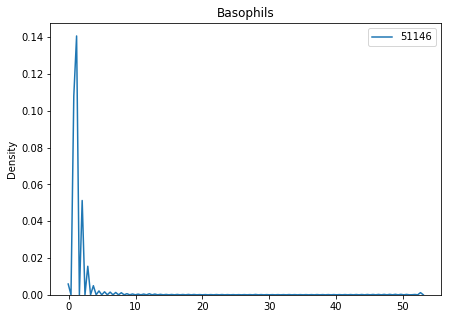

   itemid  patients      mean  median       std
0   51146     44246  0.299635     0.2  0.635749

After removing outliers:


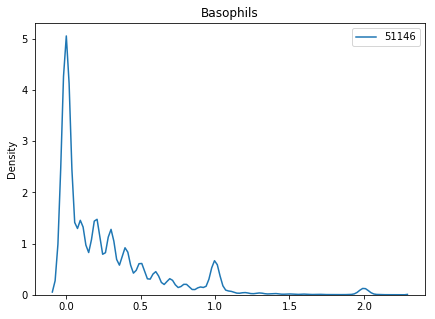

   itemid  patients      mean  median       std
0   51146     44172  0.274092     0.2  0.363448

Eosinophils

Before removing outliers:


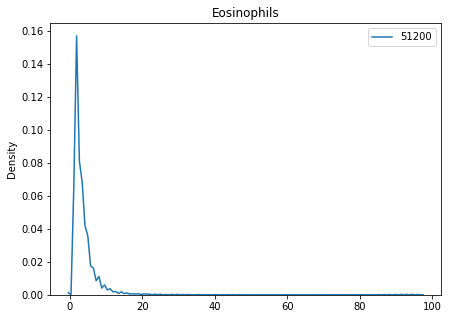

   itemid  patients      mean  median       std
0   51200     44246  1.696921     0.9  2.815068

After removing outliers:


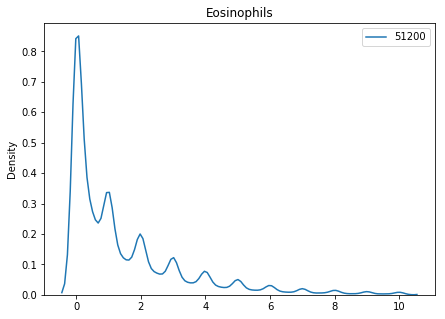

   itemid  patients      mean  median       std
0   51200     44094  1.464419     0.9  1.869913

Hematocrit

Before removing outliers:


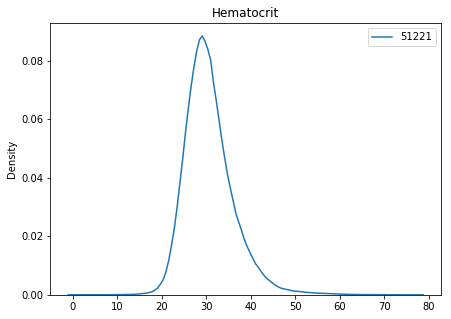

   itemid  patients       mean  median       std
0   51221     57102  30.715236    30.0  5.522901

After removing outliers:


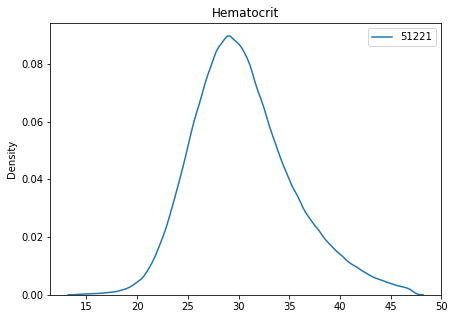

   itemid  patients       mean  median       std
0   51221     52804  30.463843    29.9  4.968125

Hemoglobin

Before removing outliers:


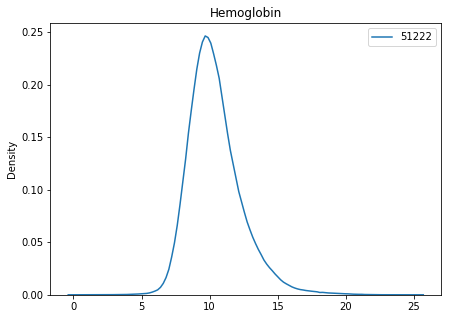

   itemid  patients      mean  median       std
0   51222     56949  10.40664    10.1  1.952585

After removing outliers:


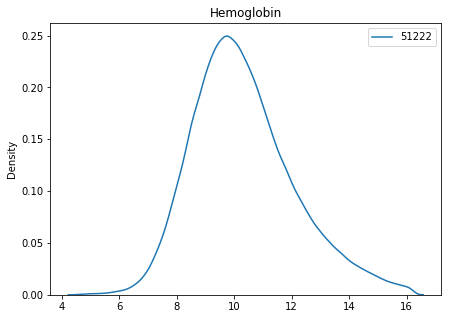

   itemid  patients       mean  median       std
0   51222     52947  10.323677    10.1  1.778098

Lymphocytes

Before removing outliers:


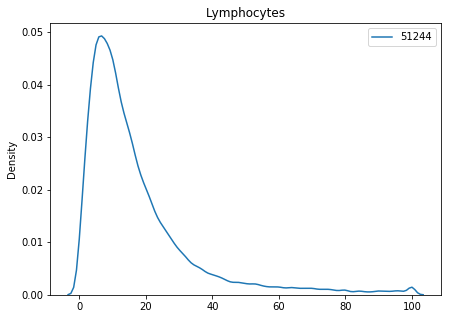

   itemid  patients       mean  median        std
0   51244     44247  17.327375    12.0  16.945853

After removing outliers:


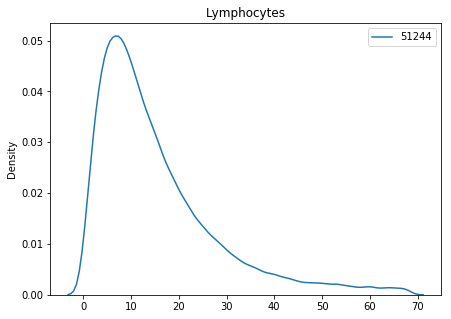

   itemid  patients       mean  median        std
0   51244     43774  15.405097    11.9  12.641068

MCH

Before removing outliers:


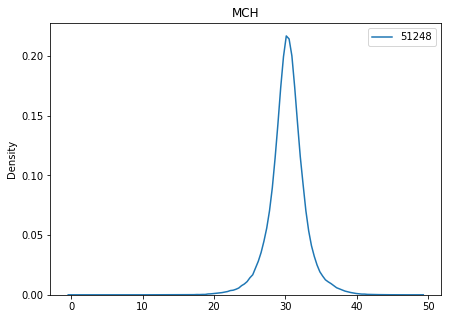

   itemid  patients       mean  median       std
0   51248     56938  30.292456    30.3  2.500433

After removing outliers:


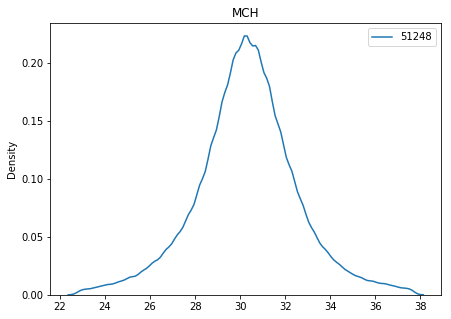

   itemid  patients       mean  median       std
0   51248     55481  30.300119    30.3  2.248281

MCHC

Before removing outliers:


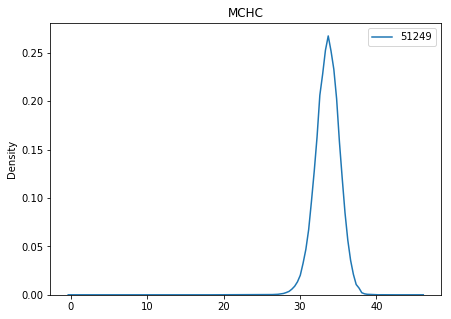

   itemid  patients       mean  median       std
0   51249     56941  33.578911    33.6  1.575285

After removing outliers:


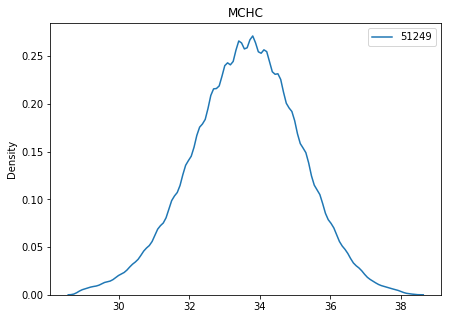

   itemid  patients       mean  median       std
0   51249     56894  33.598609    33.6  1.523018

MCV

Before removing outliers:


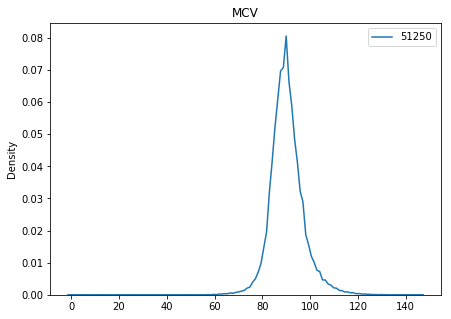

   itemid  patients       mean  median       std
0   51250     56938  90.300854    90.0  6.854976

After removing outliers:


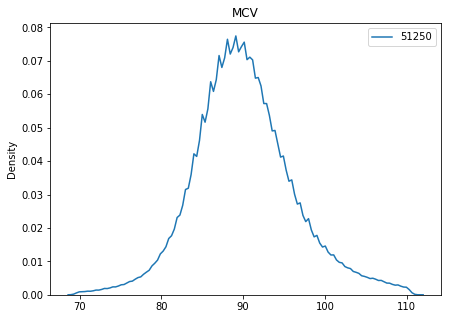

   itemid  patients       mean  median       std
0   51250     55095  90.110851    90.0  6.129328

Monocytes

Before removing outliers:


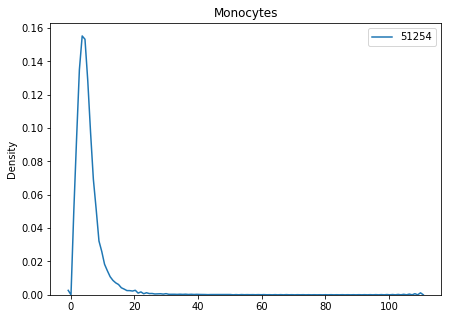

   itemid  patients      mean  median      std
0   51254     44247  5.420769     4.5  4.83894

After removing outliers:


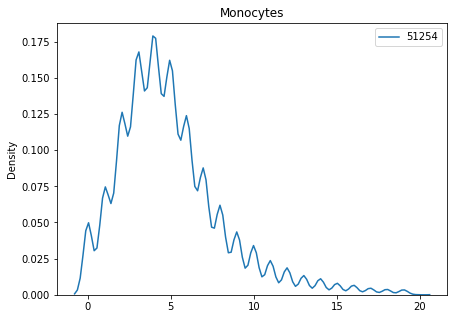

   itemid  patients      mean  median       std
0   51254     44160  4.999224     4.4  3.211409

Neutrophils

Before removing outliers:


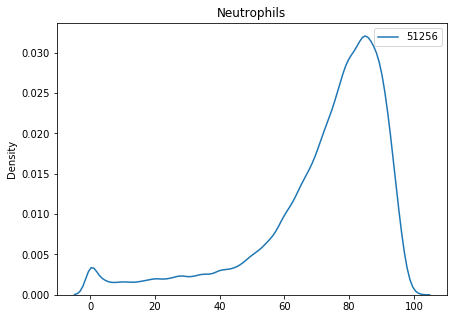

   itemid  patients       mean  median        std
0   51256     44247  71.756738    77.8  20.724846

After removing outliers:


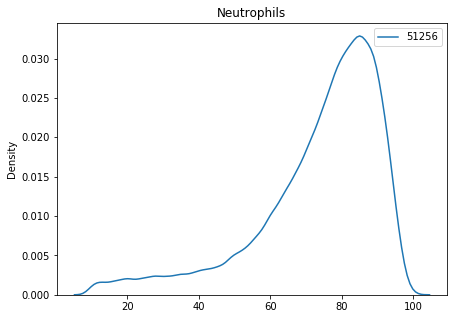

   itemid  patients       mean  median        std
0   51256     44128  73.585575    78.1  17.639552

Platelet Count

Before removing outliers:


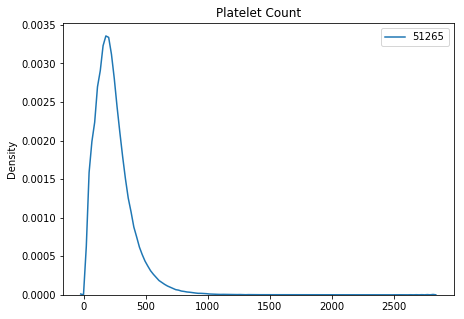

   itemid  patients        mean  median         std
0   51265     56974  236.636716   210.0  152.216988

After removing outliers:


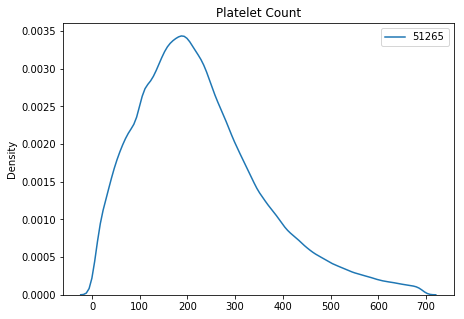

   itemid  patients        mean  median         std
0   51265     56909  227.546896   208.0  131.804492

RDW

Before removing outliers:


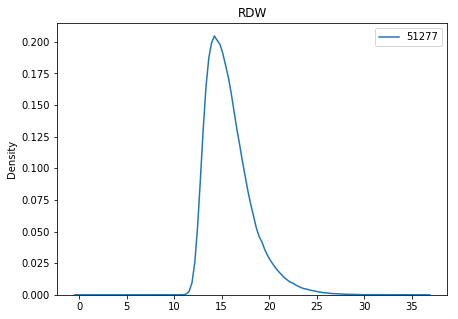

   itemid  patients       mean  median       std
0   51277     56930  15.781929    15.3  2.381525

After removing outliers:


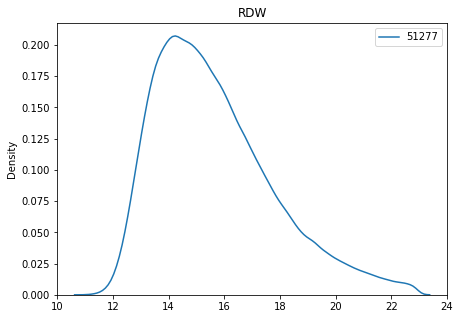

   itemid  patients       mean  median       std
0   51277     56820  15.659768    15.3  2.141176

Red Blood Cells

Before removing outliers:


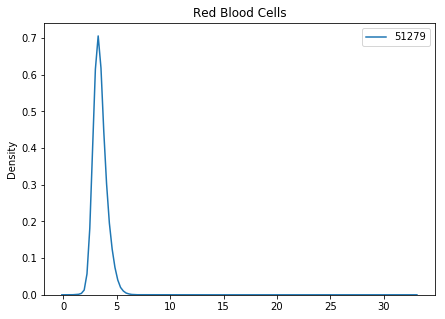

   itemid  patients     mean  median       std
0   51279     56938  3.44839    3.37  0.640932

After removing outliers:


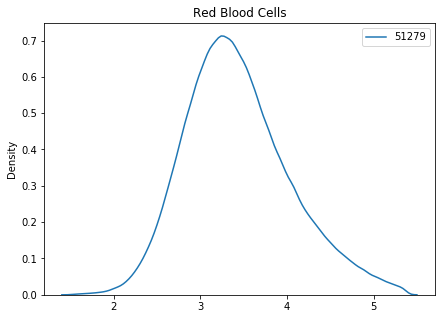

   itemid  patients      mean  median       std
0   51279     55920  3.433236    3.37  0.607688

White blood cells

Before removing outliers:


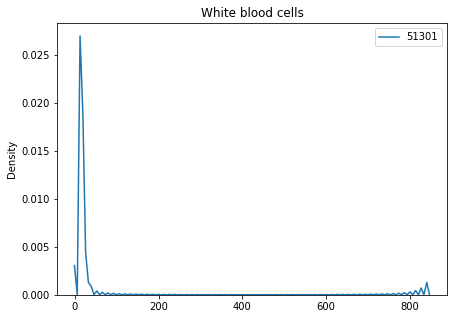

   itemid  patients       mean  median       std
0   51301     56990  11.304008     9.9  9.487122

After removing outliers:


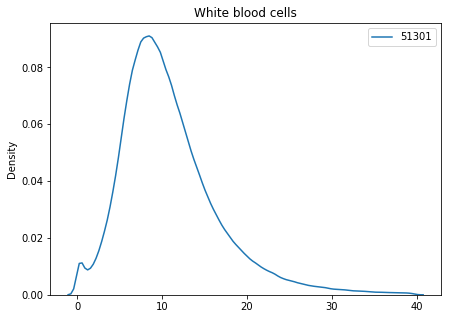

   itemid  patients       mean  median       std
0   51301     56891  10.892758     9.9  5.744257

Anion Gap

Before removing outliers:


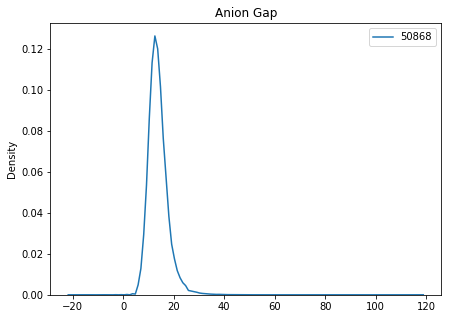

   itemid  patients       mean  median       std
0   50868     52808  13.772912    13.0  3.882666

After removing outliers:


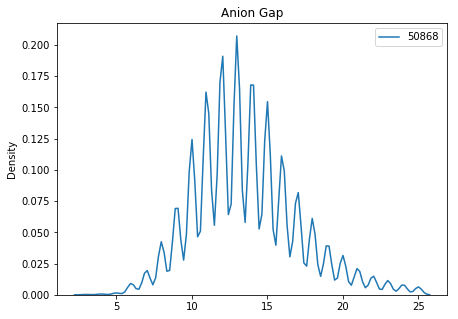

   itemid  patients      mean  median       std
0   50868     52682  13.58417    13.0  3.425031

Bicarbonate

Before removing outliers:


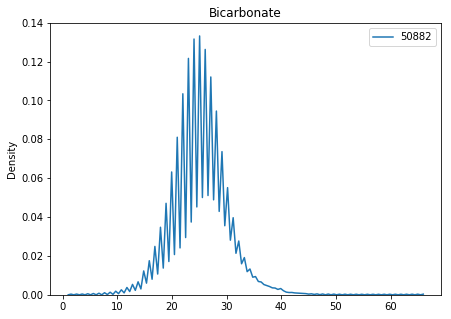

   itemid  patients       mean  median      std
0   50882     52825  25.258974    25.0  5.03566

After removing outliers:


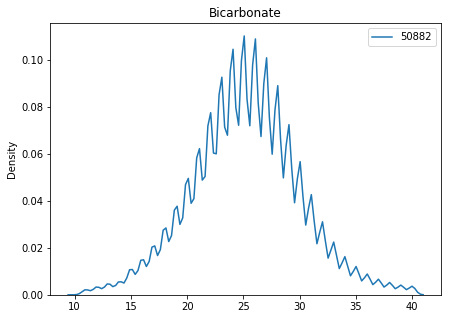

   itemid  patients       mean  median       std
0   50882     52744  25.217707    25.0  4.754739

Calcium (Total)

Before removing outliers:


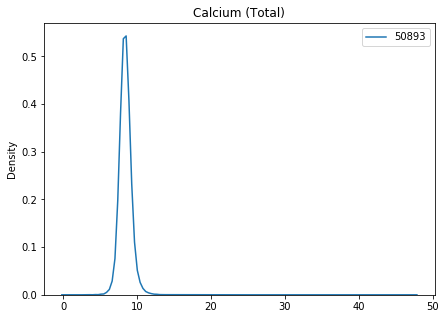

   itemid  patients      mean  median       std
0   50893     49002  8.429568     8.4  0.834552

After removing outliers:


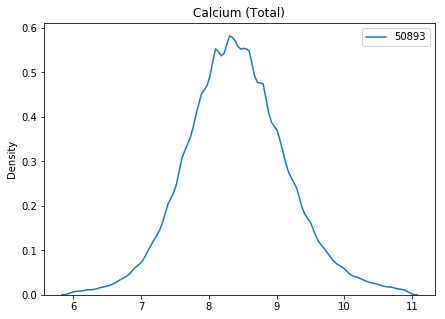

   itemid  patients      mean  median       std
0   50893     48918  8.411871     8.4  0.747782

Chloride

Before removing outliers:


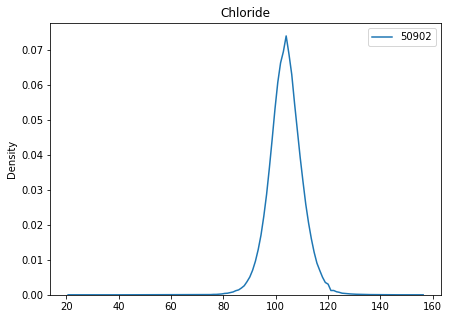

   itemid  patients        mean  median       std
0   50902     52852  103.779464   104.0  6.303991

After removing outliers:


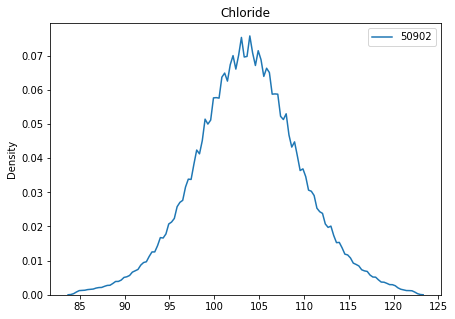

   itemid  patients       mean  median       std
0   50902     52820  103.76669   104.0  5.949302

Creatinine

Before removing outliers:


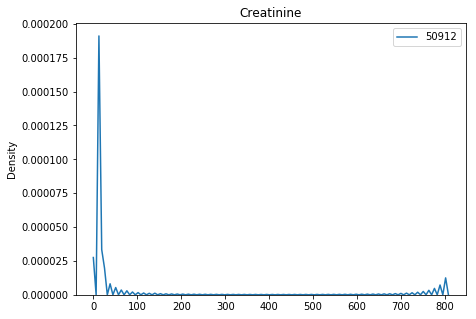

   itemid  patients      mean  median       std
0   50912     50996  1.530655     1.0  1.895441

After removing outliers:


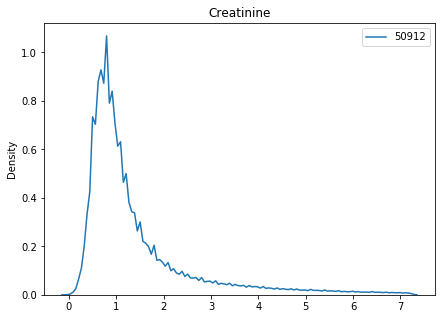

   itemid  patients      mean  median       std
0   50912     50768  1.399745     1.0  1.185649

Glucose

Before removing outliers:


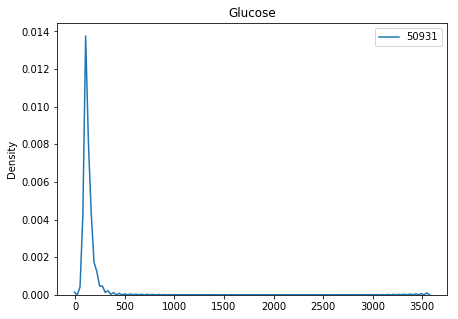

   itemid  patients        mean  median        std
0   50931     50395  132.756433   119.0  66.444797

After removing outliers:


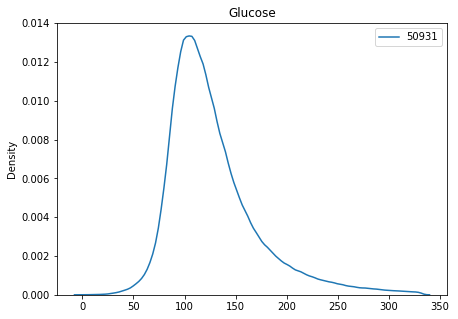

   itemid  patients        mean  median        std
0   50931     50340  127.967324   118.0  43.997325

Magnesium

Before removing outliers:


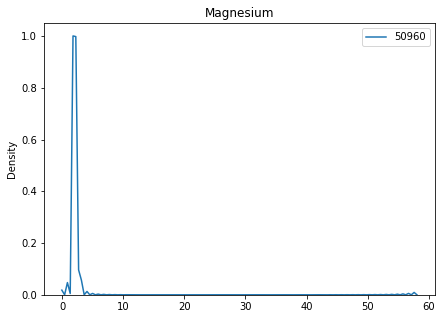

   itemid  patients      mean  median       std
0   50960     49762  2.039457     2.0  0.409426

After removing outliers:


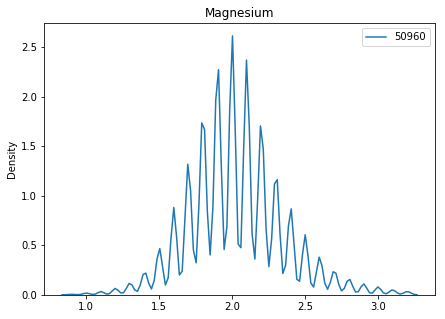

   itemid  patients      mean  median       std
0   50960     49703  2.027987     2.0  0.319837

Potassium

Before removing outliers:


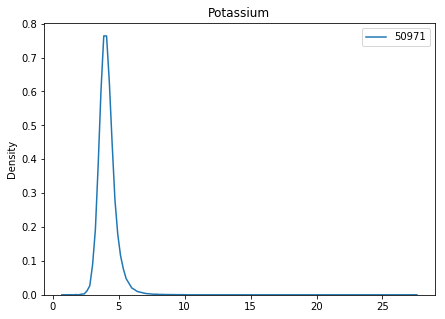

   itemid  patients      mean  median       std
0   50971     52876  4.126318     4.0  0.650398

After removing outliers:


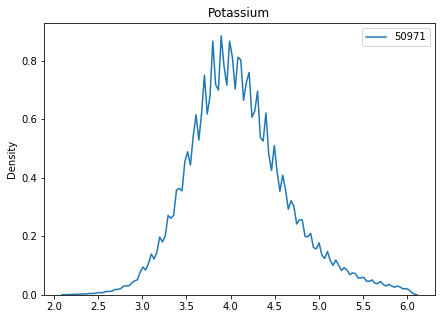

   itemid  patients      mean  median       std
0   50971     52727  4.091554     4.0  0.563087

Sodium

Before removing outliers:


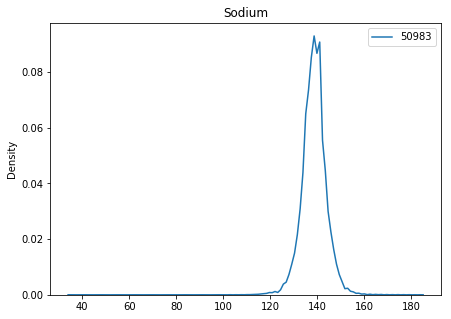

   itemid  patients        mean  median       std
0   50983     52859  138.617959   139.0  5.133123

After removing outliers:


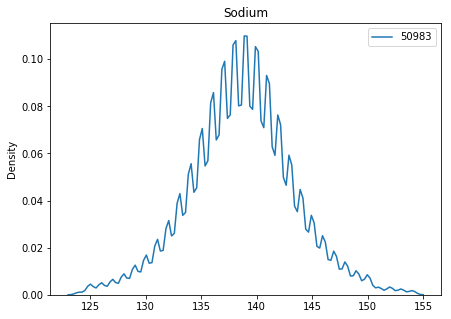

   itemid  patients        mean  median      std
0   50983     52818  138.652734   139.0  4.69385

Urea Nitrogen

Before removing outliers:


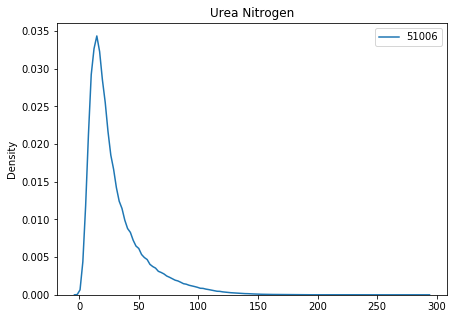

   itemid  patients      mean  median        std
0   51006     51008  30.02692    22.0  23.804153

After removing outliers:


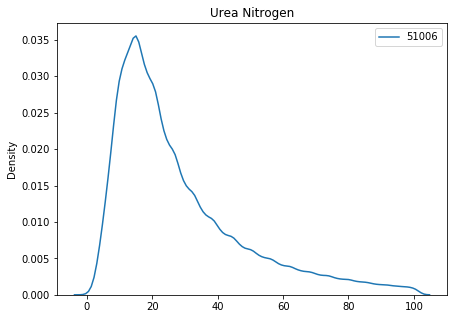

   itemid  patients       mean  median        std
0   51006     50901  28.165888    22.0  19.851674

PTT

Before removing outliers:


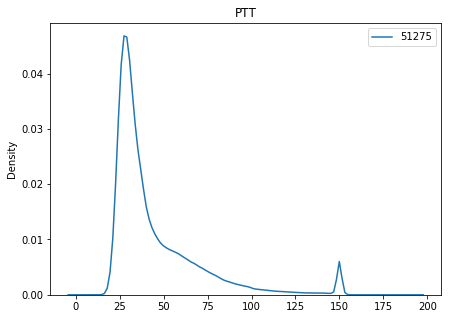

   itemid  patients       mean  median        std
0   51275     48063  44.691134    34.7  25.790675

After removing outliers:


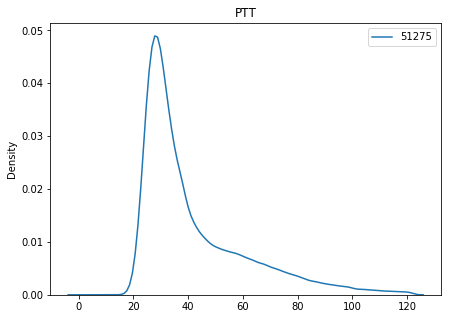

   itemid  patients       mean  median        std
0   51275     47986  41.754522    34.2  19.472958

Lactate

Before removing outliers:


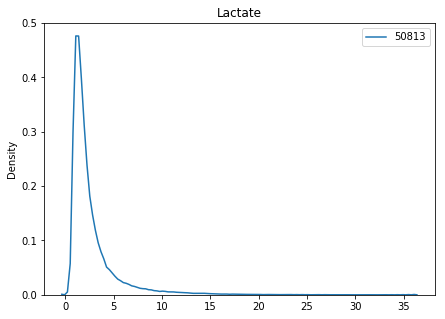

   itemid  patients      mean  median       std
0   50813     34549  2.636718     1.8  2.588021

After removing outliers:


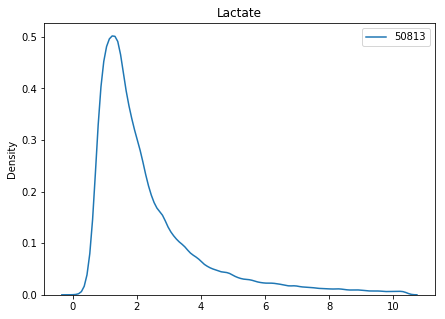

   itemid  patients      mean  median       std
0   50813     34437  2.344729     1.8  1.729496

PCO2

Before removing outliers:


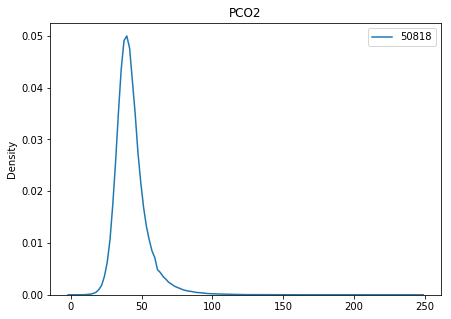

   itemid  patients       mean  median        std
0   50818     37347  42.732719    41.0  11.377772

After removing outliers:


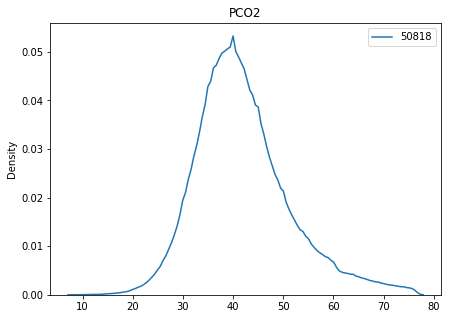

   itemid  patients       mean  median       std
0   50818     37202  41.938423    41.0  9.396434

pH

Before removing outliers:


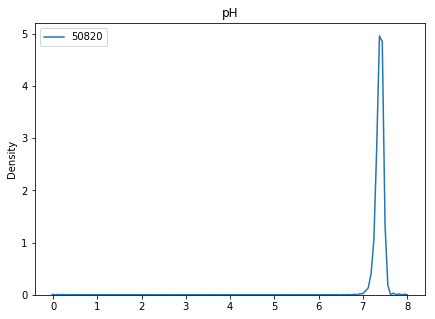

   itemid  patients     mean  median       std
0   50820     38917  7.37929    7.39  0.087134

After removing outliers:


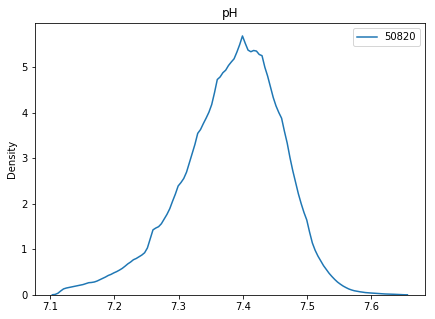

   itemid  patients      mean  median       std
0   50820     38777  7.382757    7.39  0.077633

PO2

Before removing outliers:


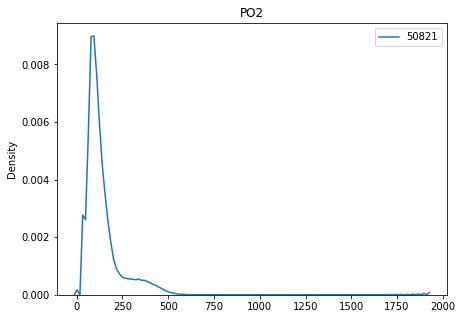

   itemid  patients        mean  median        std
0   50821     37350  136.779812   109.0  92.137273

After removing outliers:


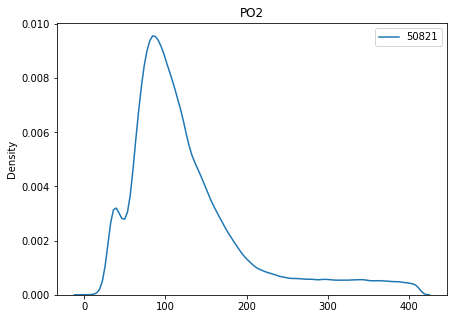

   itemid  patients        mean  median        std
0   50821     37071  128.402588   107.0  76.448717

HR

Before removing outliers:


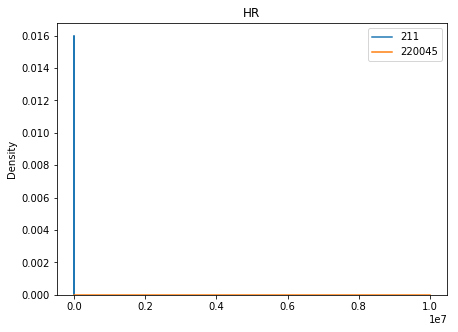

   itemid  patients        mean  median          std
0     211     34901  108.861212    97.0    36.126095
1  220045     21924   91.039794    86.0  6017.072932

After removing outliers:


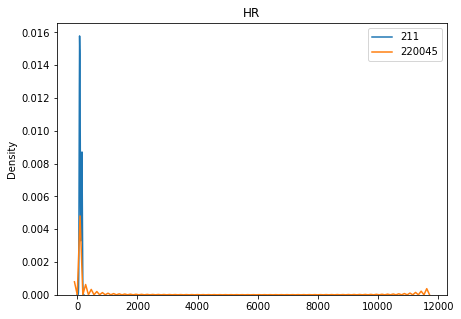

   itemid  patients        mean  median        std
0     211     34900  108.887222    97.0  36.076874
1  220045     21924   87.388417    86.0  20.725913

Oxygen saturation

Before removing outliers:


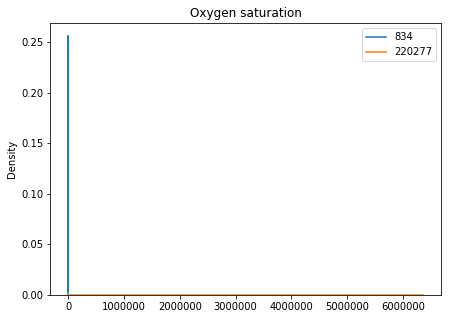

   itemid  patients        mean  median          std
0     834     17630   96.762680    97.0     3.030396
1  220277     21904  100.922544    97.0  4435.541448

After removing outliers:


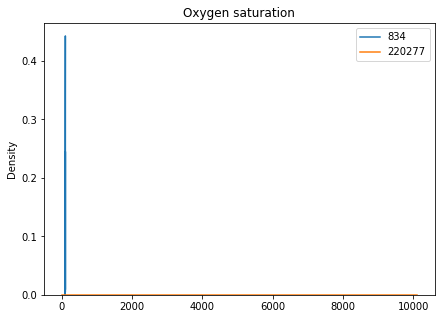

   itemid  patients       mean  median        std
0     834     17492  96.845155    97.0   2.688084
1  220277     21904  96.926237    97.0  27.132688

Temperature F

Before removing outliers:


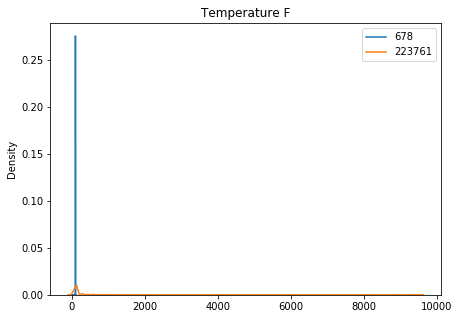

   itemid  patients       mean     median        std
0     678     26642  98.571834  98.599998   2.668473
1  223761     21673  98.407970  98.300000  14.681127

After removing outliers:


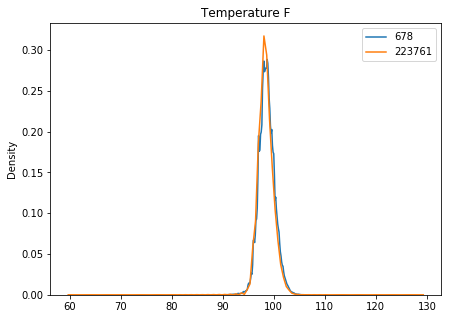

   itemid  patients       mean     median       std
0     678     26624  98.631967  98.599998  1.531440
1  223761     21650  98.431849  98.400000  1.444561

BP systolic

Before removing outliers:


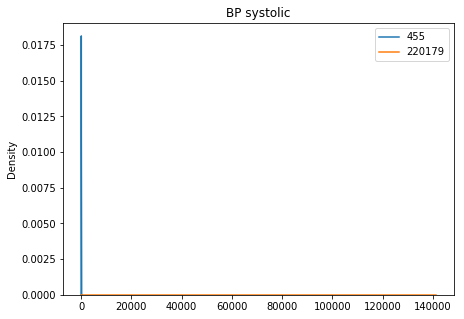

   itemid  patients        mean  median         std
0     455     26429  120.014098   118.0   23.536775
1  220179     21685  120.458251   118.0  249.608552

After removing outliers:


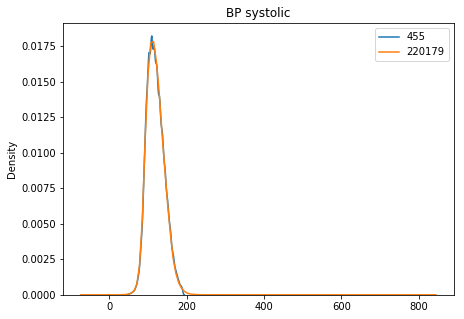

   itemid  patients        mean  median        std
0     455     26409  119.948837   118.0  22.320452
1  220179     21685  119.878841   118.0  22.555525

BP mean

Before removing outliers:


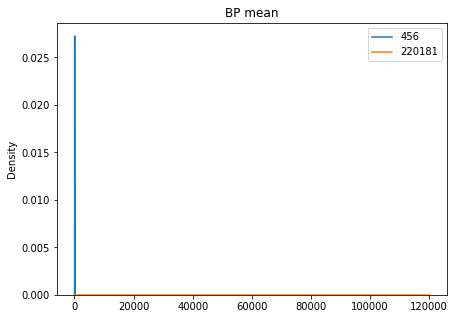

   itemid  patients       mean     median         std
0     456     26397  77.225114  75.666702   15.753650
1  220181     21676  76.673120  75.000000  174.583058

After removing outliers:


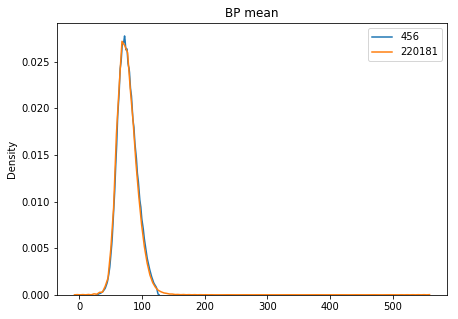

   itemid  patients       mean     median        std
0     456     26390  76.960479  75.333298  15.061097
1  220181     21676  76.304149  75.000000  15.720407

Respiratory rate

Before removing outliers:


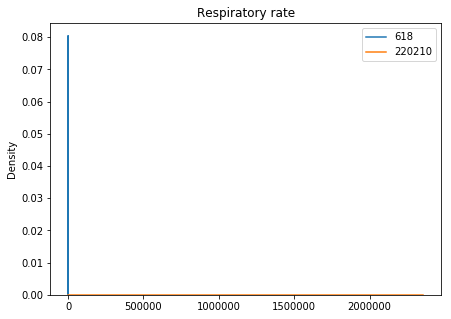

   itemid  patients       mean  median          std
0     618     27195  20.133307    20.0     6.406810
1  220210     21913  20.923463    20.0  1423.805365

After removing outliers:


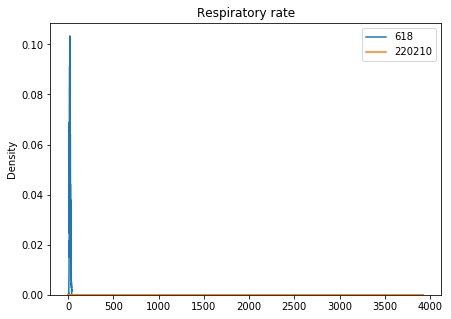

   itemid  patients       mean  median       std
0     618     27193  20.052310    20.0  5.886978
1  220210     21913  20.062869    20.0  7.969872

BP diastolic

Before removing outliers:


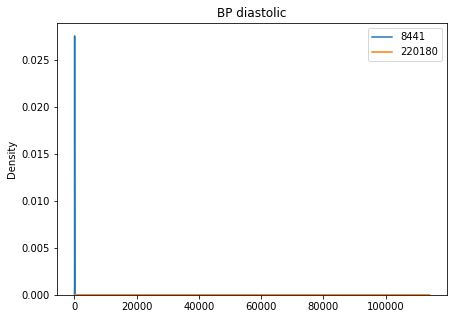

   itemid  patients       mean  median         std
0    8441     26411  58.027487    57.0   15.567736
1  220180     21685  65.183290    61.0  389.373326

After removing outliers:


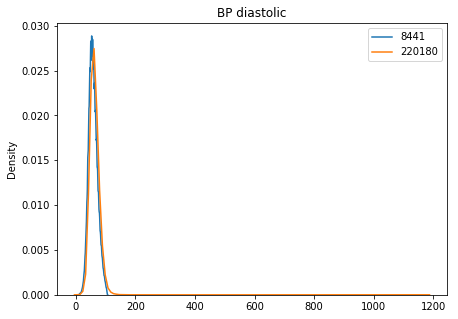

   itemid  patients       mean  median        std
0    8441     26407  57.790707    57.0  14.866665
1  220180     21685  62.831124    61.0  15.720790

BUN

Before removing outliers:


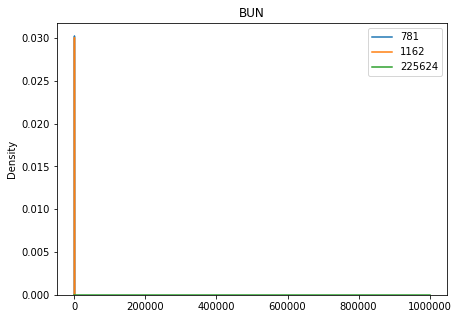

   itemid  patients       mean  median          std
0     781     27354  32.960824    24.0    25.892186
1    1162     21108  32.887724    25.0    25.663993
2  225624     24062  38.393725    24.0  2561.058040

After removing outliers:


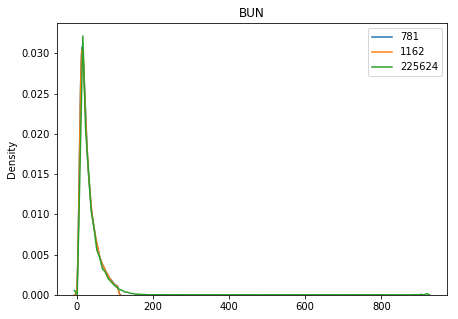

   itemid  patients       mean  median        std
0     781     27267  31.182167    24.0  22.356992
1    1162     21033  31.128458    24.0  22.132993
2  225624     24062  31.835144    24.0  25.547410

Phosphorus

Before removing outliers:


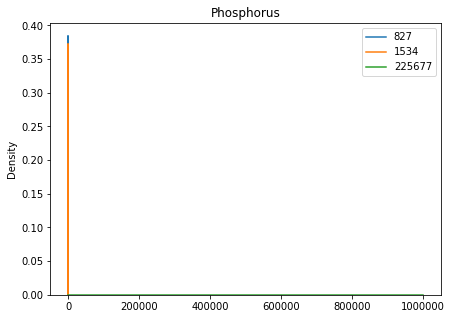

   itemid  patients       mean  median          std
0     827     24839   3.666046     3.4     1.451076
1    1534     20585   3.649682     3.4     1.452145
2  225677     22617  10.940608     3.3  2717.259785

After removing outliers:


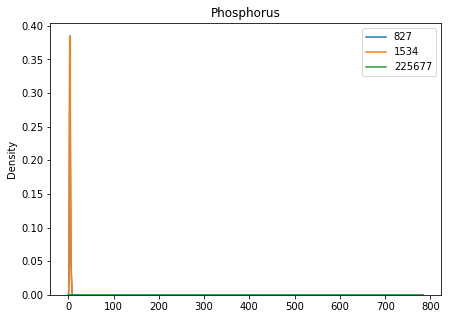

   itemid  patients      mean  median       std
0     827     24721  3.567889     3.4  1.224009
1    1534     20485  3.557393     3.4  1.242246
2  225677     22617  3.557081     3.3  2.606914

Admission weight

Before removing outliers:


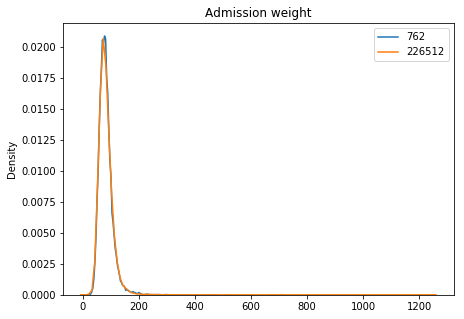

   itemid  patients       mean  median        std
0     762     20045  81.149934    78.0  23.625398
1  226512     21920  81.054447    77.8  26.085891

After removing outliers:


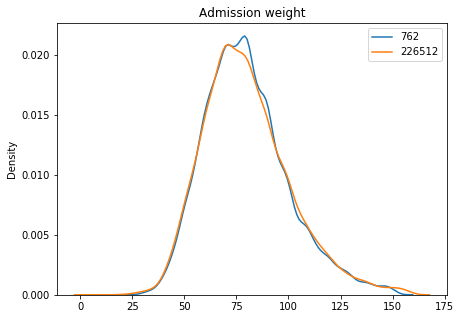

   itemid  patients       mean     median        std
0     762     19840  79.737759  77.900002  20.109615
1  226512     21712  79.948507  77.500000  20.940258

QA STATS:
Original DF length:  46825764
Original unique admissions:  58294
New DF length:  43002318
New unique admissions:  58289


In [9]:
df = remove_outliers(df=df, ids='new_id', sigma=3)

In [10]:
# ---- MANUAL CLEANING

# Find equivalent min and max values from Carevue

# Heart_rate
hr_low = df[df['itemid']==211].valuenum.min()
hr_high = df[df['itemid']==211].valuenum.max()

# Respiratory_rate
rr_low = df[df['itemid']==618].valuenum.min()
rr_high = df[df['itemid']==618].valuenum.max()

# Phosphorus
p_low = df[(df['itemid']==827) | (df['itemid']==1534)].valuenum.min()
p_high = df[(df['itemid']==827) | (df['itemid']==1534)].valuenum.max()

# Oxygen saturation
os_low = df[df['itemid']==834].valuenum.min()
os_high = df[df['itemid']==834].valuenum.max()

In [11]:
# HR (Metavision)
def manual_range_change(df, new_id, low, high):
    df['valuenum'] = np.where((df['valuenum']>high) & (df['new_id']==new_id), np.nan, df['valuenum'])
    df['valuenum'] = np.where((df['valuenum']<low) & (df['new_id']==new_id), np.nan, df['valuenum'])
    compare_itemids(df[df['new_id']==new_id])
    df.dropna(inplace=True)
    return df

/Users/James/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/James/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/James/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumva

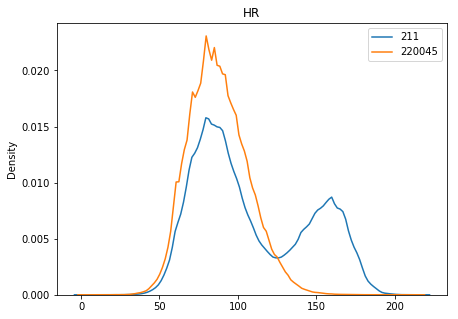

   itemid  patients        mean  median        std
0     211     34900  108.887222    97.0  36.076874
1  220045     21924   87.409335    86.0  18.715403


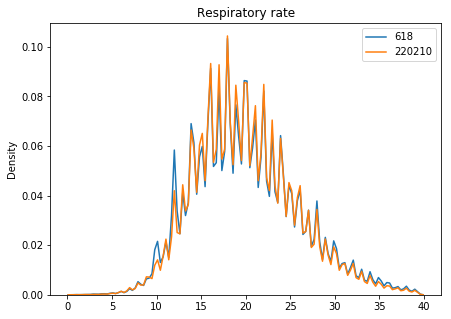

   itemid  patients       mean  median       std
0     618     27193  20.052310    20.0  5.886978
1  220210     21913  20.020554    20.0  5.631525


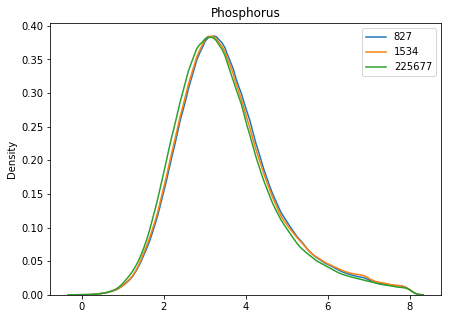

   itemid  patients      mean  median       std
0     827     24721  3.567889     3.4  1.224009
1    1534     20485  3.557393     3.4  1.242246
2  225677     22516  3.469069     3.3  1.219192


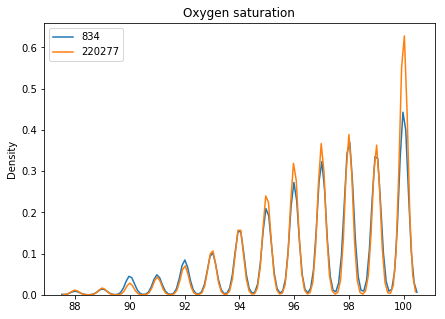

   itemid  patients       mean  median       std
0     834     17492  96.845155    97.0  2.688084
1  220277     21890  97.068821    97.0  2.612080


In [12]:
df = manual_range_change(df, 9999018, hr_low, hr_high)
df = manual_range_change(df, 9999025, rr_low, rr_high)
df = manual_range_change(df, 9999022, p_low, p_high)
df = manual_range_change(df, 9999040, os_low, os_high)

In [13]:
# Get first reading per admission
first_reading = (df.sort_values(by=['subject_id', 'hadm_id', 'new_id', 'charttime'])
                   .groupby(['subject_id', 'hadm_id', 'new_id'])
                   .first()
                   .reset_index())

# Pivot
first_reading=(pd.pivot_table(first_reading, values='valuenum', index=['subject_id', 'hadm_id'], columns='name')
                 .reset_index())
print("Total df length: ", len(first_reading))

to_s3(obj=first_reading, bucket='mimic-jamesi', filename='first_reading.csv')
first_reading.head(100)

Total df length:  58289


name  subject_id   hadm_id  Admission weight  Anion Gap  BP diastolic  \
0              2  163353.0               NaN        NaN           NaN   
1              3  145834.0         96.800003       17.0          24.0   
2              4  185777.0               NaN       17.0          63.0   
3              5  178980.0               NaN        NaN           NaN   
4              6  107064.0               NaN       23.0          40.0   
5              7  118037.0               NaN        NaN           NaN   
6              8  159514.0               NaN        NaN           NaN   
7              9  150750.0        104.000000       13.0           NaN   
8             10  184167.0               NaN       17.0           NaN   
9             11  194540.0               NaN       13.0          42.0   
10            12  112213.0         75.000000       16.0          72.0   
11            13  143045.0         73.500000       14.0          51.0   
12            16  103251.0               NaN        NaN           NaN   
13            17  161087.0         68.000000       20.0          59.0   
14            17  194023.0         67.900002       12.0           NaN   
15            18  188822.0               NaN       18.0          88.0   
16            19  109235.0               NaN       20.0          55.0   
17            20  157681.0         93.300003       12.0          54.0   
18            21  109451.0         65.599998       22.0          56.0   
19            21  111970.0         64.000000       19.0          60.0   
20            22  165315.0               NaN       13.0          65.0   
21            23  124321.0         66.800000       13.0          45.0   
22            23  152223.0         72.099998       12.0          60.0   
23            24  161859.0        120.000000       14.0          78.0   
24            25  129635.0        100.400002       19.0          52.0   
25            26  197661.0               NaN       12.0          45.0   
26            27  134931.0               NaN        NaN           NaN   
27            28  162569.0         96.000000       13.0          54.0   
28            30  104557.0         65.699997       18.0          63.0   
29            31  128652.0         74.000000        9.0          69.0   
..           ...       ...               ...        ...           ...   
70            70  178596.0               NaN        NaN           NaN   
71            71  111944.0         70.000000       16.0          56.0   
72            72  156857.0               NaN       18.0           NaN   
73            73  194730.0         80.000000       15.0          64.0   
74            74  182637.0               NaN        NaN           NaN   
75            75  112086.0         88.800003        9.0          39.0   
76            77  142768.0         98.000000       16.0          87.0   
77            78  100536.0         72.400002        8.0          97.0   
78            79  181542.0         77.199997       13.0          57.0   
79            80  115385.0         85.000000       16.0          67.0   
80            81  175016.0               NaN       17.0          66.0   
81            82  110641.0               NaN        NaN           NaN   
82            83  158569.0               NaN       17.0          23.0   
83            84  120969.0               NaN       16.0           NaN   
84            84  166401.0               NaN       12.0          80.0   
85            85  112077.0         98.000000       14.0          87.0   
86            85  116630.0         84.000000       15.0          63.0   
87            86  190243.0         79.199997       14.0          47.0   
88            87  190659.0               NaN       18.0           NaN   
89            88  123010.0         95.199997       18.0          60.0   
90            89  188646.0               NaN        NaN           NaN   
91            91  121205.0         45.500000       20.0          52.0   
92            92  142807.0               NaN       15.0   